In [42]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
import skimage.transform
import ast
import pandas as pd
import numpy as np
import math
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array as img_to_array
from tensorflow.keras.preprocessing.image import load_img as load_img
import tensorflow.keras.preprocessing.image as tf_image
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as backend
import tensorflow.keras.regularizers as regularizers
import tensorflow.keras.models as models
import tensorflow.keras.metrics as metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import cv2

%matplotlib inline
np.random.seed(1)


In [43]:
# set constant variables
IM_SIZE = 128 
NUM_EPOCHS = 5
BATCH_SIZE = 32
L2_WEIGHT_DECAY = 5e-4
BATCH_NORM_DECAY = 0.99
BATCH_NORM_EPSILON = 1e-5
ROOT_DIR = "C:\\train2014\\"
LBL_FILE = "C:\\train.txt"
DATA_FRAC=0.8

# Train and Test set Split

In [44]:
label = np.genfromtxt(LBL_FILE,dtype='str')[:,1]
image  = np.genfromtxt(LBL_FILE,dtype='str')[:,0]
print(label)
label_split = []
label_int = []
img_list = []
for i in range(0,label.shape[0]):
    label_split.append(label[i].split(','))
    label_int.append(list(map(int, label_split[i])))
    
#for i in range(0,image.shape[0]):
#    img_list.append(ROOT_DIR + image[i])   

label = np.array(label_int)
print(label[0])
print(label.shape)

['13,18' '19' '10' ... '19' '18,19' '16']
[13, 18]
(31925,)


In [45]:
one_hot = MultiLabelBinarizer()
label_one_hot = one_hot.fit_transform(label)

#Check
print(label[0])
print(label_one_hot[0])


[13, 18]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0]


In [46]:

data_full = pd.DataFrame(np.genfromtxt('train.txt',dtype='str'))  
data_full[3] = label_one_hot.tolist()

In [47]:
X_train_df = data_full.sample(frac=DATA_FRAC,random_state=200)
X_train =  (ROOT_DIR + X_train_df[0]).tolist()
Y_train =  X_train_df[3].tolist()



In [48]:
X_test = (ROOT_DIR + data_full.loc[~data_full.index.isin(X_train_df.index)][0]).tolist()
Y_test = data_full.loc[~data_full.index.isin(X_train_df.index)][3].tolist()

In [49]:
len(X_train)

25540

In [50]:
len(Y_train)

25540

In [51]:
t_size = int(len(X_train)*90/100)

In [52]:
len(X_train[:t_size])

22986

display few sample images from the train dataset

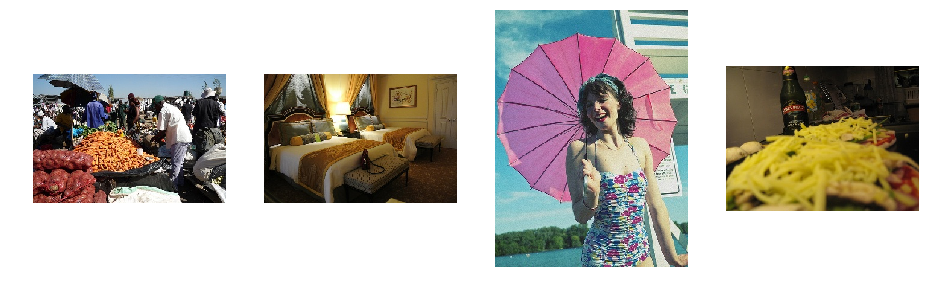

In [53]:
#mean of imagenet dataset in BGR
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

current_dir = os.getcwd()

#Modify the image_dir to your local path to images
image_dir = os.path.join(ROOT_DIR)

%matplotlib inline

#get list of all images
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
#load all images
imgs = []
i=1
for f in img_files:
    if i<5:
        i+=1
        imgs.append(cv2.imread(f))
    
#plot images
fig = plt.figure(figsize=(20,10))
for i, img in enumerate(imgs):
    fig.add_subplot(1,5,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

Compare different image resolutions

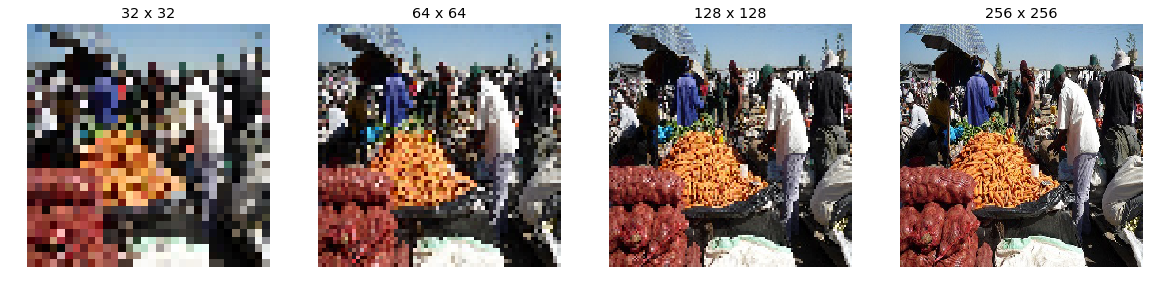

In [61]:
fig = plt.figure(figsize=(20,10))
for i in range(0, 4):
    res = [32,64,128,256]
    fig.add_subplot(1,4,i+1)
    img = img_to_array(load_img(ROOT_DIR+'0.jpg', target_size=(res[i], res[i])))/255.
    plt.imshow(img)
    plt.title(str(res[i])+' x '+str(res[i]))
    plt.axis('off')

# ResNet50 Architecture and Impelemetation


In [27]:
def identity_block(input_tensor, kernel_size, filters):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
    """
    filters1, filters2, filters3 = filters
    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.Conv2D(filters1, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(input_tensor)

    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size,
                      padding='same', use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(x)

    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)

    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(x)

    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

In [28]:
def conv_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3,
    the second conv layer at main path is with strides=(2, 2)
    And the shortcut should have strides=(2, 2) as well
    """

    filters1, filters2, filters3 = filters

    if backend.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.Conv2D(filters1, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(input_tensor)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)


    x = layers.Conv2D(filters2, kernel_size, strides=strides, padding='same',
                      use_bias=False, kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(x)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(x)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)

    # Add CONV2D to match up input/output dimensions
    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, use_bias=False,
                             kernel_initializer='he_normal',
                             kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                            )(input_tensor)
    shortcut = layers.BatchNormalization(axis=bn_axis,
                                         momentum=BATCH_NORM_DECAY,
                                         epsilon=BATCH_NORM_EPSILON)(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [29]:
def resnet50(num_classes, input_shape):
    img_input = layers.Input(shape=input_shape)

    if backend.image_data_format() == 'channels_first':
        x = layers.Lambda(lambda x: backend.permute_dimensions(x, (0, 3, 1, 2)),
                          name='transpose')(img_input)
        bn_axis = 1
    else:  # channels_last
        x = img_input
        bn_axis = 3

    # Conv1 (7x7,64,stride=2)
    x = layers.ZeroPadding2D(padding=(3, 3))(x)

    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid', use_bias=False,
                      kernel_initializer='he_normal',
                      kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
                     )(x)
    x = layers.BatchNormalization(axis=bn_axis,
                                  momentum=BATCH_NORM_DECAY,
                                  epsilon=BATCH_NORM_EPSILON)(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)

    # 3x3 max pool,stride=2
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Conv2_x

    # 1×1, 64
    # 3×3, 64
    # 1×1, 256

    x = conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256])
    x = identity_block(x, 3, [64, 64, 256])

    # Conv3_x
    #
    # 1×1, 128
    # 3×3, 128
    # 1×1, 512

    x = conv_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])

    # Conv4_x
    # 1×1, 256
    # 3×3, 256
    # 1×1, 1024
    x = conv_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])

    # 1×1, 512
    # 3×3, 512
    # 1×1, 2048
    x = conv_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])

    # average pool, 1000-d fc, softmax
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(
        num_classes, activation='sigmoid',
        name='imgclass',
        kernel_regularizer=regularizers.l2(L2_WEIGHT_DECAY),
        bias_regularizer=regularizers.l2(L2_WEIGHT_DECAY)
    )(x)

    # Create model.
    return models.Model(img_input, x, name='resnet50')

In [30]:
model=resnet50(20,(IM_SIZE, IM_SIZE, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [31]:
model.compile(loss = metrics.binary_crossentropy,
              #optimizer = tf.train.MomentumOptimizer(learning_rate= 1e-5 , momentum=0.9),
              optimizer= tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),#'adam',
              #metrics = [metrics.categorical_accuracy])             
              metrics=['accuracy','top_k_categorical_accuracy',metrics.categorical_accuracy])

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation

# Train and Validate Model

In [33]:

def load_image(image_path, size):
    # data augmentation logic such as random rotations can be added here
    return img_to_array(load_img(image_path, target_size=(size, size))) / 255.

class GeneratorSequence(tf.keras.utils.Sequence):
    """
    Custom Sequence object to train a model on out-of-memory datasets. 
    """
    
    def __init__(self, im_size, batch_size,x,y, mode='train'):
        """
        // add description
        
        """
        self.im_size = im_size
        self.batch_size = batch_size
        self.mode = mode

        # Take labels and a list of image locations in memory
        self.glabels = y 
        self.image_list = x 

        
    def __len__(self):
        return int(math.ceil(len(self.image_list) / float(self.batch_size)))

    def on_epoch_end(self):
        # Shuffles indexes after each epoch
        self.indexes = range(len(self.image_list))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))

    def get_batch_labels(self, idx): 
        # Fetch a batch of labels
        return [self.glabels[idx * self.batch_size: (idx + 1) * self.batch_size]]

    def get_batch_features(self, idx):
        # Fetch a batch of images
        batch_images = self.image_list[idx * self.batch_size: (1 + idx) * self.batch_size]
        return np.array([load_image(im, self.im_size) for im in batch_images])

    def __getitem__(self, idx):
        batch_x = self.get_batch_features(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_x, batch_y

In [34]:
%%time
# Sequence guarantees the ordering and guarantees the single use of every input per epoch when using
seq = GeneratorSequence(im_size=IM_SIZE, batch_size=BATCH_SIZE, x=X_train[:t_size],y=Y_train[:t_size] )
seq_val = GeneratorSequence(im_size=IM_SIZE, batch_size=BATCH_SIZE, x=X_train[t_size:],y=Y_train[t_size:] )

callbacks = [tf.keras.callbacks.ModelCheckpoint('./model.h5', verbose=1)]

H = model.fit_generator(generator=seq,
                    verbose=1, 
                    epochs=NUM_EPOCHS,
                    validation_data=seq_val,
                #    use_multiprocessing=True,
                #    workers=4,
                    callbacks=callbacks
                       )

model.save_weights("./resnet50_finetuned_tfOPT.h5")


Instructions for updating:
Use tf.cast instead.
Epoch 1/5
80/80 [==============================] - 145s 2s/step - loss: 23.3130 - acc: 0.9357 - top_k_categorical_accuracy: 0.5434 - categorical_accuracy: 0.1413

Epoch 00001: saving model to ./model.h5
719/719 [==============================] - 14947s 21s/step - loss: 25.0596 - acc: 0.9353 - top_k_categorical_accuracy: 0.4657 - categorical_accuracy: 0.1259 - val_loss: 23.3130 - val_acc: 0.9357 - val_top_k_categorical_accuracy: 0.5434 - val_categorical_accuracy: 0.1413
Epoch 2/5
80/80 [==============================] - 142s 2s/step - loss: 20.2181 - acc: 0.9359 - top_k_categorical_accuracy: 0.5922 - categorical_accuracy: 0.1915

Epoch 00002: saving model to ./model.h5
719/719 [==============================] - 14392s 20s/step - loss: 21.7279 - acc: 0.9361 - top_k_categorical_accuracy: 0.5923 - categorical_accuracy: 0.1788 - val_loss: 20.2181 - val_acc: 0.9359 - val_top_k_categorical_accuracy: 0.5922 - val_categorical_accuracy: 0.1915
Epoc

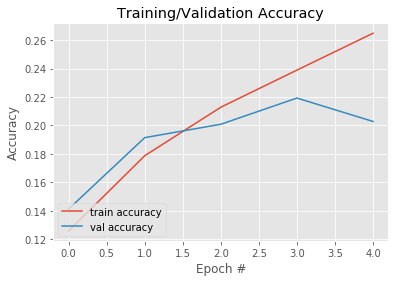

In [35]:
# plot the training loss and accuracy
N = NUM_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["categorical_accuracy"], label="train accuracy")
plt.plot(np.arange(0, N), H.history["val_categorical_accuracy"], label="val accuracy")
plt.title("Training/Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

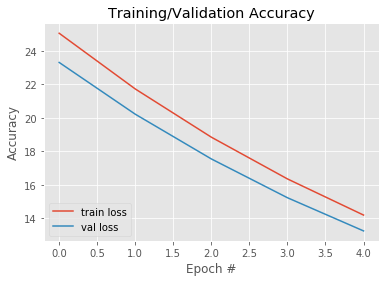

In [36]:
# plot the training loss and accuracy
N = NUM_EPOCHS

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val loss")
plt.title("Training/Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

# Predict Result

In [37]:
test_seq =  GeneratorSequence( 
                       im_size=IM_SIZE,
                       batch_size=BATCH_SIZE, x=X_test,y=Y_test, mode='test')
predictions = model.predict_generator(generator=test_seq, verbose=1)


200/200 [==============================] - 355s 2s/step


In [38]:
def pred_accuracy(y_p,y_t):
    """Helper function to calculate accuracy"""  
    m = 0
    for i in range (len(y_t)):
        for j in range(len(y_p[i,:])):
            if  y_t[i,j]==1 and y_p[i,:].argmax(axis=0) == j:         
                m = m + 1       
    acc = m /(float(len(y_t)))*100
    print(m)
    return acc  

In [39]:
acc = pred_accuracy( predictions,np.array(Y_test) )

1612


In [40]:
len(Y_test)

6385

In [41]:
acc

25.24667188723571